## This notebook
- uses the `hwwprocessor_nocuts` processor which doesn't apply any cuts but saves the cuts as bools for us to test and cross-check
- runs over DY samples... one root file per pt bin
- makes stacked hist plots to compare the different cuts
- makes 2d plots to cross-check any pair of variables (e.g. lep_pt vs jet_pt)

In [1]:
import json
import uproot
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from coffea import nanoevents
from coffea import processor
import time

import argparse
import warnings
import pyarrow as pa
import pyarrow.parquet as pq
import pickle as pkl
import pandas as pd
import os
import sys
sys.path.append("../")

from collections import defaultdict
import pickle as pkl
import pyarrow as pa
import awkward as ak
import numpy as np
import pandas as pd
import json
import os
import shutil
import pathlib
from typing import List, Optional
import pyarrow.parquet as pq

from coffea import processor
from coffea.nanoevents.methods import candidate, vector
from coffea.analysis_tools import Weights, PackedSelection
from boostedhiggs.utils import match_HWW
from boostedhiggs.btag import btagWPs
from boostedhiggs.btag import BTagCorrector

import hist as hist2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import mplhep as hep
from hist.intervals import clopper_pearson_interval

import warnings
warnings.filterwarnings("ignore", message="Found duplicate branch ")
warnings.filterwarnings("ignore", category=DeprecationWarning)
np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
job_name = '/0-1'
channels=['ele', 'mu', 'had']
pt_bins = ["DYJetsToLL_Pt-50To100", "DYJetsToLL_Pt-100To250", "DYJetsToLL_Pt-250To400", "DYJetsToLL_Pt-400To650", "DYJetsToLL_Pt-650ToInf" ]
pt_bins = ["DYJetsToLL_Pt-50To100"]

# Run the processor

In [3]:
# define the configuration and processor
for pt_bin in pt_bins:
    fileset = {}
    print(f"Processing pt_bin: {pt_bin}")
    fileset[pt_bin] = [f"../datafiles/DY/{pt_bin}.root"]

    outfiles = "./DY/" + pt_bin + "/"

    # remove output directory to store fresh samples
    if os.path.exists(outfiles):
        shutil.rmtree(outfiles)

    from boostedhiggs.hwwprocessor_nocuts import HwwProcessor_nocuts
    p = HwwProcessor_nocuts(year='2017', channels=channels, output_location=outfiles + job_name)
    
    executor = processor.IterativeExecutor(status=True)
    run = processor.Runner(
        executor=executor, savemetrics=True, schema=nanoevents.NanoAODSchema, chunksize=10000
    )

    out, metrics = run(
    fileset, "Events", processor_instance=p
    )

    # dump to pickle
    filehandler = open(outfiles + job_name + '.pkl', "wb")
    pkl.dump(out, filehandler)
    filehandler.close()

    # merge parquet
    for ch in channels:
        data = pd.read_parquet(outfiles + job_name + ch + '/parquet')
        data.to_parquet(outfiles + job_name + '_' + ch + '.parquet')

        # remove old parquet files
        os.system('rm -rf ' + outfiles + job_name + ch)

        data_jets = pd.read_parquet(outfiles + job_name + '/jets/' + ch + '/parquet')
        data_jets.to_parquet(outfiles + job_name + '_jets_' + ch + '.parquet')

    # remove old parquet files
    os.system('rm -rf ' + outfiles + job_name)        

Processing pt_bin: DYJetsToLL_Pt-50To100


Preprocessing:   0%|          | 0/1 [00:00<?, ?file/s]

Processing:   0%|          | 0/10 [00:00<?, ?chunk/s]

# Load the output files

In [4]:
data = {}
data_jets = {}
metadata = {}

for pt_bin in pt_bins:
    data[pt_bin] = {}
    data_jets[pt_bin] = {}
    
    outfiles = "./DY/" + pt_bin + "/"
    
    for ch in channels:  
        data[pt_bin][ch] = pq.read_table(outfiles + job_name + '_' + ch + '.parquet').to_pandas()
        data_jets[pt_bin][ch] = pq.read_table(outfiles + job_name + '_jets_' + ch + '.parquet').to_pandas()

    with open(outfiles + job_name + '.pkl', 'rb') as f:
        metadata[pt_bin] = pkl.load(f)

# No cuts applied yet

## 1D-histograms of lep_pt for each DY pt bin

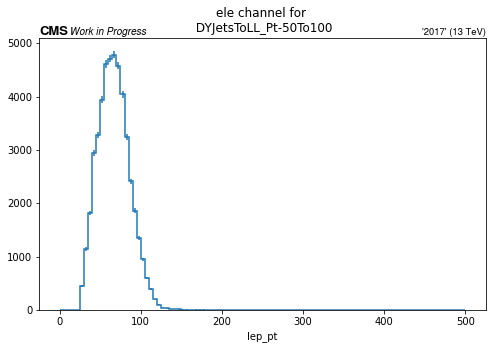

In [5]:
for pt_bin in pt_bins:
    h = hist2.Hist(
        hist2.axis.Regular(100,0, 500, name='lep_pt', label='lep_pt', flow=True),
    )
    h.fill(data[pt_bin]['ele']['lep_pt']
          )

    odir = './DY/' + pt_bin + '/'
    fig, ax = plt.subplots(figsize=(8, 5))
    hep.histplot(h, ax=ax)
    # ax.set_xlabel(f"{'btag_max'}")
    ax.set_title(f'ele channel for \n {pt_bin}')
    hep.cms.lumitext(f"'2017' (13 TeV)", ax=ax)
    hep.cms.text("Work in Progress", ax=ax)

    if not os.path.exists(f'{odir}/'):
        os.makedirs(f'{odir}/')

    plt.savefig(f'{odir}/lep_pt_wth_btag_threshold.pdf')

## 1D-histograms of lep_pt stacked over bins

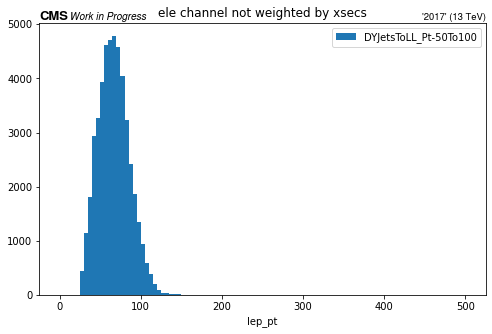

In [6]:
# stacked
h = hist2.Hist(
    hist2.axis.Regular(100,0, 500, name='lep_pt', label='lep_pt', flow=True),
    hist2.axis.StrCategory([], name='PT bin', label=pt_bin, growth=True),
)
for pt_bin in pt_bins:
    h.fill(data[pt_bin]['ele']['lep_pt'], pt_bin
          )

odir = './DY/'

fig, ax = plt.subplots(figsize=(8, 5))
hep.histplot([h[{"PT bin": pt_bin}] for pt_bin in pt_bins], stack=True, sort='yield', histtype="fill", ax=ax, label=[pt_bin for pt_bin in pt_bins])
ax.set_title(f'ele channel not weighted by xsecs')
hep.cms.lumitext(f"'2017' (13 TeV)", ax=ax)
hep.cms.text("Work in Progress", ax=ax)
ax.legend()

if not os.path.exists(f'{odir}/'):
    os.makedirs(f'{odir}/')

plt.savefig(f'{odir}/lep_pt_stacked_noxsecs.pdf')
plt.show()
plt.close();

In [13]:
# scale by xsecs
import glob
def get_sum_sumgenweight(pt_bin):
    pkl_files = glob.glob(f'./DY/{pt_bin}/*.pkl')  # get the pkl metadata of the pkl files that were processed
    sum_sumgenweight = 0
    for file in pkl_files:
        # load and sum the sumgenweight of each
        with open(file, 'rb') as f:
            metadata = pkl.load(f)
        sum_sumgenweight = sum_sumgenweight + metadata[pt_bin]['2017']['sumgenweight']
    return sum_sumgenweight

def get_xsec_weight(pt_bin):
    f = open('../fileset/xsec_pfnano.json')
    xsec = json.load(f)
    f.close()
    return (eval(str((xsec[pt_bin]))) / (get_sum_sumgenweight(pt_bin)))

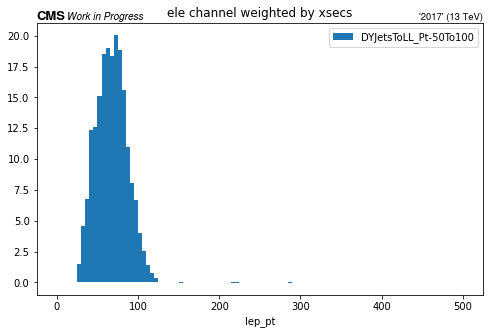

In [16]:
# stacked scaled by xsecs
h = hist2.Hist(
    hist2.axis.Regular(100,0, 500, name='lep_pt', label='lep_pt', flow=True),
    hist2.axis.StrCategory([], name='PT bin', label=pt_bin, growth=True),
)
for pt_bin in pt_bins:
    event_weight = data[pt_bin]['ele']['weight']
    h.fill(data[pt_bin]['ele']['lep_pt'], pt_bin, weight= event_weight * get_xsec_weight(pt_bin)
          )

odir = './DY/'

fig, ax = plt.subplots(figsize=(8, 5))
hep.histplot([h[{"PT bin": pt_bin}] for pt_bin in pt_bins], stack=True, sort='yield', histtype="fill", ax=ax, label=[pt_bin for pt_bin in pt_bins])
ax.set_title(f'ele channel weighted by xsecs')
hep.cms.lumitext(f"'2017' (13 TeV)", ax=ax)
hep.cms.text("Work in Progress", ax=ax)
ax.legend()

# ax.set_yscale('log')
# ax.set_ylim(0.1)

if not os.path.exists(f'{odir}/'):
    os.makedirs(f'{odir}/')

plt.savefig(f'{odir}/lep_pt_stacked_xsecs.pdf')
plt.show()
plt.close();

# Register cuts

In [17]:
normal_cuts = ['lep_pt', 'oneElectron', 'notaus_ele', 'ElectronIsolation', 'mt_lep_met']
normal_plus_btag = ['lep_pt', 'oneElectron', 'notaus_ele', 'ElectronIsolation', 'mt_lep_met', 'anti_bjettag']
normal_plus_dR = ['lep_pt', 'oneElectron', 'notaus_ele', 'ElectronIsolation', 'mt_lep_met', 'leptonInJet']
normal_plus_btag_plus_dR = ['lep_pt', 'oneElectron', 'notaus_ele', 'ElectronIsolation', 'mt_lep_met', 'anti_bjettag', 'leptonInJet']

# Register cuts# make a cut dict to map the "cut label" to the actual cut
cut_dict = {}
for pt_bin in pt_bins:
    cut_dict[pt_bin] = {'lep_pt':            (data[pt_bin]['ele']['leptonKin']>40),
                        'oneElectron':       (data[pt_bin]['ele']['oneElectron']),
                        'notaus_ele':        (data[pt_bin]['ele']['notaus_ele']),''
                        'ElectronIsolation': (data[pt_bin]['ele']['ElectronIsolation']==1),
                        'mt_lep_met':        (data[pt_bin]['ele']['mt_lep_met']==1),
                        'anti_bjettag':      (data[pt_bin]['ele']['anti_bjettag']==1),
                        'leptonInJet':       (data[pt_bin]['ele']['leptonInJet']==1)
                       }

def apply_cuts(pt_bin, cuts = ['lep_pt', 'oneElectron', 'notaus_ele', 'ElectronIsolation', 'mt_lep_met', 'anti_bjettag', 'leptonInJet']):

    '''
    takes as input a list of cut names (any of the "cutdict" keys defined above)
    returns output as a boolean array to apply on the events
    '''
    for i, cut in enumerate(cuts):
        if i==0:
            combined_bool = cut_dict[pt_bin][cut]
        else:
            combined_bool = pd.concat([combined_bool,cut_dict[pt_bin][cut]], axis=1)
    
    if len(cuts)==1:
        return combined_bool
    return combined_bool.all(axis=1)

# Apply cuts and make stacked histograms

In [18]:
def plot(cut_choice, label, xsecs):
    
    '''
    takes as input
    (1) a cut_choice from the ones define above
    (2) a label for the title of the hist
    (3) boolean for xsecs to specefy whether to weight PT bins by xsecs 
    '''
    
    h = hist2.Hist(
        hist2.axis.Regular(50,0, 250, name='lepton_pt', label='lepton_pt', flow=True),
        hist2.axis.StrCategory([], name='PT bin', growth=True)
    )

    for pt_bin in pt_bins:
        if xsecs:
            event_weight = data[pt_bin]['ele']['weight'].clip(lower=0)[apply_cuts(pt_bin, cut_choice)]
            
            h.fill(
                data[pt_bin]['ele']['lep_pt'][apply_cuts(pt_bin, cut_choice)], pt_bin, weight= event_weight * get_xsec_weight(pt_bin)
            )
        else:
            h.fill(
                data[pt_bin]['ele']['lep_pt'][apply_cuts(pt_bin, cut_choice)], pt_bin,
            )

    odir = './DY/'

    fig, ax = plt.subplots(figsize=(8, 5))
    hep.histplot([h[{"PT bin": pt_bin}] for pt_bin in pt_bins], stack=True, sort='yield', histtype="fill", ax=ax, label=[pt_bin for pt_bin in pt_bins])
    ax.set_xlabel(f"{'lep_pt'}")
    
    if xsecs:
        ax.set_title(f'ele channel after applying {label} \n weighted by xsecs')
    else:    
        ax.set_title(f'ele channel after applying {label} \n not weighted by xsecs')
    
    hep.cms.lumitext(f"2017 (13 TeV)", ax=ax)
    hep.cms.text("Work in Progress", ax=ax)
    ax.legend(loc='upper left')

    ax.set_yscale('log')
#     ax.set_ylim(0.1)
    if not os.path.exists(f'{odir}/'):
        os.makedirs(f'{odir}/')

    plt.savefig(f'{odir}/{cut_choice}_noxsecs.pdf')
    #     plt.close()    


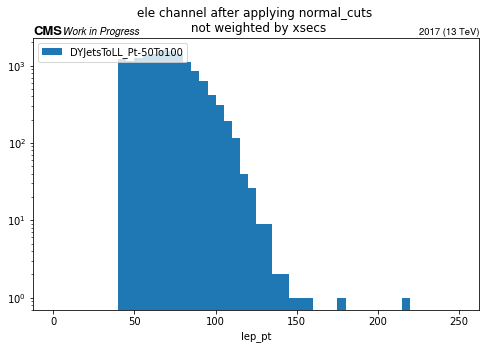

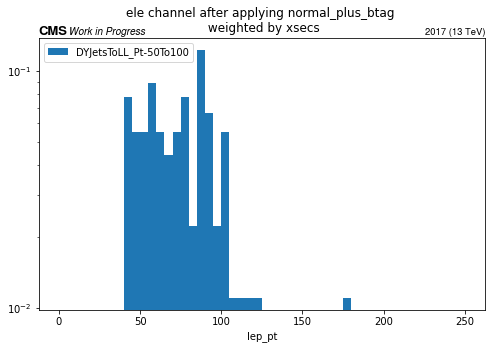

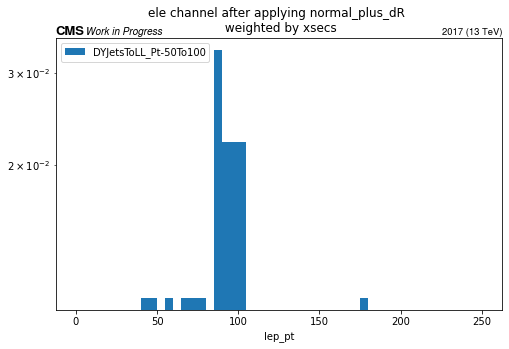

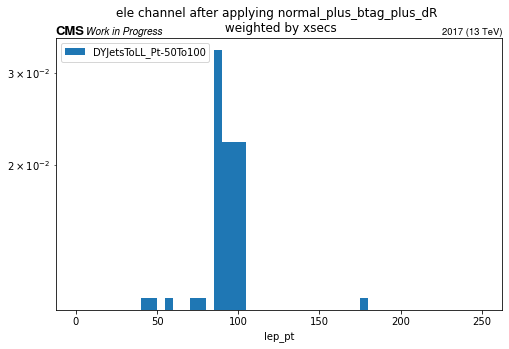

In [19]:
plot(normal_cuts, 'normal_cuts', xsecs=False)
plot(normal_plus_btag, 'normal_plus_btag', xsecs=True)
plot(normal_plus_dR, 'normal_plus_dR', xsecs=True)
plot(normal_plus_btag_plus_dR, 'normal_plus_btag_plus_dR', xsecs=True)

# 2D-plot

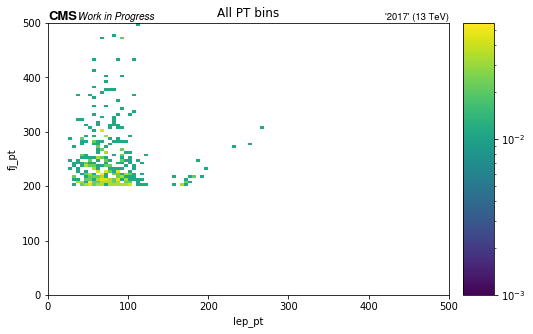

In [20]:
# btag vs lep_pt
h = hist2.Hist(
    hist2.axis.Regular(100,0, 500, name='lep_pt', label='lep_pt', flow=True),    
    hist2.axis.Regular(100,0, 500, name='fj_pt', label='fj_pt', flow=True),
    hist2.axis.StrCategory([], name='PT bin', growth=True),
)

for pt_bin in pt_bins:
    event_weight = data[pt_bin]['ele']['weight'].clip(lower=0)
    h.fill(data[pt_bin]['ele']['lep_pt'], data[pt_bin]['ele']['fj_pt'], pt_bin, weight= event_weight * get_xsec_weight(pt_bin)
    )

odir = './DY/'

fig, ax = plt.subplots(figsize=(8, 5))
hep.hist2dplot(h[{"PT bin": sum}], ax=ax, norm=matplotlib.colors.LogNorm(vmin=1e-3))    
ax.set_title(f'All PT bins')
hep.cms.lumitext(f"'2017' (13 TeV)", ax=ax)
hep.cms.text("Work in Progress", ax=ax)


if not os.path.exists(f'{odir}/'):
    os.makedirs(f'{odir}/')

plt.savefig(f'{odir}/fj_pt_vs_lep_pt_before_cuts.pdf')

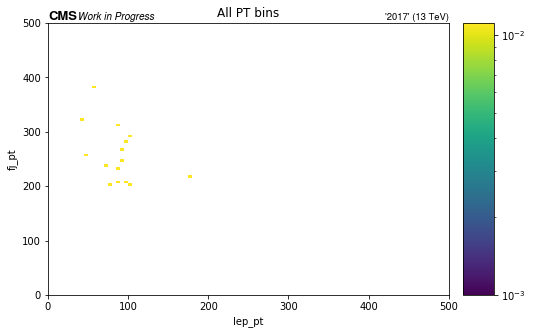

In [21]:
normal_cuts = ['lep_pt', 'oneElectron', 'notaus_ele', 'ElectronIsolation', 'mt_lep_met']
normal_plus_btag = ['lep_pt', 'oneElectron', 'notaus_ele', 'ElectronIsolation', 'mt_lep_met', 'anti_bjettag']
normal_plus_dR = ['lep_pt', 'oneElectron', 'notaus_ele', 'ElectronIsolation', 'mt_lep_met', 'leptonInJet']
normal_plus_btag_plus_dR = ['lep_pt', 'oneElectron', 'notaus_ele', 'ElectronIsolation', 'mt_lep_met', 'anti_bjettag', 'leptonInJet']


cut_choice = normal_plus_btag_plus_dR

# btag vs lep_pt
h = hist2.Hist(
    hist2.axis.Regular(100,0, 500, name='lep_pt', label='lep_pt', flow=True),    
    hist2.axis.Regular(100,0, 500, name='fj_pt', label='fj_pt', flow=True),
    hist2.axis.StrCategory([], name='PT bin', growth=True),
)

for pt_bin in pt_bins:
    event_weight = data[pt_bin]['ele']['weight'][apply_cuts(pt_bin, cut_choice)].clip(lower=0)
    h.fill(data[pt_bin]['ele']['lep_pt'][apply_cuts(pt_bin, cut_choice)], data[pt_bin]['ele']['fj_pt'][apply_cuts(pt_bin, cut_choice)], pt_bin, weight= event_weight * get_xsec_weight(pt_bin)
    )

odir = './DY/'

fig, ax = plt.subplots(figsize=(8, 5))
hep.hist2dplot(h[{"PT bin": sum}], ax=ax, norm=matplotlib.colors.LogNorm(vmin=1e-3))    
ax.set_title(f'All PT bins')
hep.cms.lumitext(f"'2017' (13 TeV)", ax=ax)
hep.cms.text("Work in Progress", ax=ax)

if not os.path.exists(f'{odir}/'):
    os.makedirs(f'{odir}/')

plt.savefig(f'{odir}/fj_pt_vs_lep_pt_after_cuts.pdf')

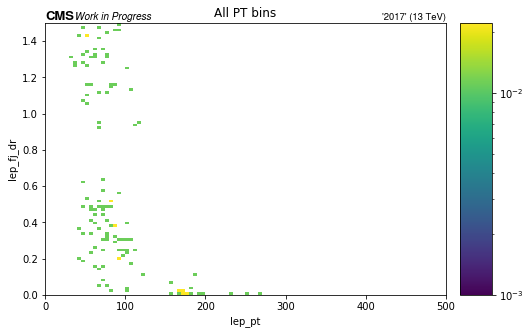

In [22]:
normal_cuts = ['lep_pt', 'oneElectron', 'notaus_ele', 'ElectronIsolation', 'mt_lep_met']
normal_plus_btag = ['lep_pt', 'oneElectron', 'notaus_ele', 'ElectronIsolation', 'mt_lep_met', 'anti_bjettag']
normal_plus_dR = ['lep_pt', 'oneElectron', 'notaus_ele', 'ElectronIsolation', 'mt_lep_met', 'leptonInJet']
normal_plus_btag_plus_dR = ['lep_pt', 'oneElectron', 'notaus_ele', 'ElectronIsolation', 'mt_lep_met', 'anti_bjettag', 'leptonInJet']


cut_choice = normal_plus_btag_plus_dR

# btag vs lep_pt
h = hist2.Hist(
    hist2.axis.Regular(100,0, 500, name='lep_pt', label='lep_pt', flow=True),    
    hist2.axis.Regular(100,0, 1.5, name='lep_fj_dr', label='lep_fj_dr', flow=True),
    hist2.axis.StrCategory([], name='PT bin', growth=True),
)

for pt_bin in pt_bins:
    event_weight = data[pt_bin]['ele']['weight'].clip(lower=0)
    h.fill(data[pt_bin]['ele']['lep_pt'], data[pt_bin]['ele']['lep_fj_dr'], pt_bin, weight= event_weight * get_xsec_weight(pt_bin)
    )

odir = './DY/'

fig, ax = plt.subplots(figsize=(8, 5))
hep.hist2dplot(h[{"PT bin": sum}], ax=ax, norm=matplotlib.colors.LogNorm(vmin=1e-3))    
ax.set_title(f'All PT bins')
hep.cms.lumitext(f"'2017' (13 TeV)", ax=ax)
hep.cms.text("Work in Progress", ax=ax)

if not os.path.exists(f'{odir}/'):
    os.makedirs(f'{odir}/')

plt.savefig(f'{odir}/lep_fj_dr_vs_lep_pt_before_cuts.pdf')

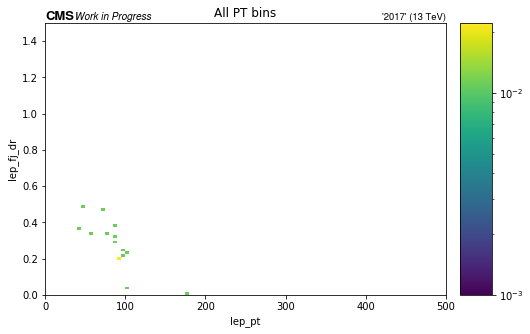

In [23]:
normal_cuts = ['lep_pt', 'oneElectron', 'notaus_ele', 'ElectronIsolation', 'mt_lep_met']
normal_plus_btag = ['lep_pt', 'oneElectron', 'notaus_ele', 'ElectronIsolation', 'mt_lep_met', 'anti_bjettag']
normal_plus_dR = ['lep_pt', 'oneElectron', 'notaus_ele', 'ElectronIsolation', 'mt_lep_met', 'leptonInJet']
normal_plus_btag_plus_dR = ['lep_pt', 'oneElectron', 'notaus_ele', 'ElectronIsolation', 'mt_lep_met', 'anti_bjettag', 'leptonInJet']


cut_choice = normal_plus_btag_plus_dR

# btag vs lep_pt
h = hist2.Hist(
    hist2.axis.Regular(100,0, 500, name='lep_pt', label='lep_pt', flow=True),    
    hist2.axis.Regular(100,0, 1.5, name='lep_fj_dr', label='lep_fj_dr', flow=True),
    hist2.axis.StrCategory([], name='PT bin', growth=True),
)

for pt_bin in pt_bins:
    event_weight = data[pt_bin]['ele']['weight'][apply_cuts(pt_bin, cut_choice)].clip(lower=0)
    h.fill(data[pt_bin]['ele']['lep_pt'][apply_cuts(pt_bin, cut_choice)], data[pt_bin]['ele']['lep_fj_dr'][apply_cuts(pt_bin, cut_choice)], pt_bin, weight= event_weight * get_xsec_weight(pt_bin)
    )

odir = './DY/'

fig, ax = plt.subplots(figsize=(8, 5))
hep.hist2dplot(h[{"PT bin": sum}], ax=ax, norm=matplotlib.colors.LogNorm(vmin=1e-3))    
ax.set_title(f'All PT bins')
hep.cms.lumitext(f"'2017' (13 TeV)", ax=ax)
hep.cms.text("Work in Progress", ax=ax)

if not os.path.exists(f'{odir}/'):
    os.makedirs(f'{odir}/')

plt.savefig(f'{odir}/lep_fj_dr_vs_lep_pt_after_cuts.pdf')